In [2]:
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import jieba
import re
from math import sqrt

In [3]:
df = pd.read_excel('日记.xlsx')

In [4]:
client = pymongo.MongoClient('localhost',27017)
db = client.diary
column = db.diary
#每次重新插入数据库时，都要先清空
column.delete_many({})
for index in range(df.shape[0]):
    try:
        everyday = dict(df.iloc[index])
    #     del everyday['日期']
        column.insert_one(everyday)
    except:
        print(index)
        print(everyday['日期'])

In [5]:
cursor = column.find()
cursor_new = cursor.clone()
keys = list(cursor_new[0].keys())
word_len = {}
text = ''
everyday_text = {}
for day in cursor_new:
    word_num = 0
    everyday_text[day['日期']] = ''
    for key in keys:
        #统计是字符串的值，其他暂不能统计
        if key != '_id' and type(day[key]) == str:
            word_num += len(day[key])
            text += day[key]
            everyday_text[day['日期']] += day[key]
    word_len[day['日期']] = word_num
# print(word_len)
# print(len(text))
# print(everyday_text['2020.3.23'])

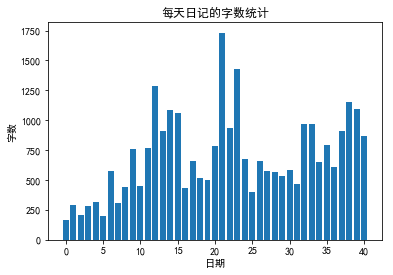

In [6]:
# list(word_len.keys())
# word_len.values
#正常显示中文
plt.rcParams["font.sans-serif"] = ["SimHei"]

plt.bar(range(len(word_len.keys())), word_len.values())
plt.xlabel("日期")
plt.ylabel('字数')
plt.title('每天日记的字数统计')
plt.show()

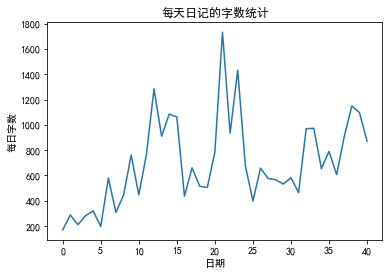

In [7]:
plt.plot(range(len(word_len.keys())), word_len.values())
plt.xlabel("日期")
plt.ylabel('每日字数')
plt.title('每天日记的字数统计')
plt.show()

### 每天字数增加进度折线
思路来源:
>得到APP，每天听本书，《暗时间》，提到进度条

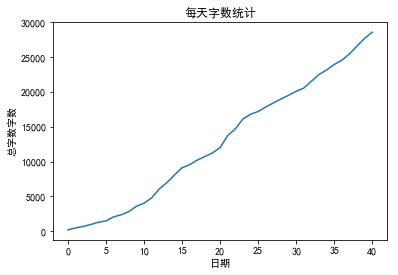

In [8]:
everyday_word_len = word_len.values()
increase_word_len = []
sum_len = 0
for each in everyday_word_len:
    sum_len += each
    increase_word_len.append(sum_len)
plt.plot(range(len(increase_word_len)), increase_word_len)
plt.xlabel("日期")
plt.ylabel('总字数字数')
plt.title('每天字数统计')
plt.show()

In [9]:
words = list(word_len.values())
word_sum = np.sum(words)
word_mean = np.mean(words)
word_median = np.median(words)
print('总字数：',word_sum,'\n','平均字数：',word_mean,'\n','字数中位数：',word_median)

总字数： 28575 
 平均字数： 696.9512195121952 
 字数中位数： 653.0


## 统计日记中的词频

### 1. 获得日记中的所有文本，并且分词

In [10]:
def jieba_depart(text):
    test_text = text
    test_text = re.sub(r'[^\u4e00-\u9fa5]+', '', test_text) #把非汉字的字符去掉
    word_depart = jieba.cut(test_text)
    words = list(word_depart)
    return words

words = jieba_depart(text)
# print(words)
# for word in words:
#     print(word)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hp\AppData\Local\Temp\jieba.cache
Loading model cost 0.991 seconds.
Prefix dict has been built successfully.


### 2. 把列表中的单词统计词频

In [11]:

def get_word_num(word_list):
    word_num_dict = {}
    for word in word_list:
        if word not in word_num_dict:
            word_num_dict.setdefault(word,1)
        else:
            word_num_dict[word] += 1
    return word_num_dict

word_num_dict = get_word_num(words)

'''
plt.bar(range(len(word_num_dict.keys())), word_num_dict.values())
plt.xlabel("单词")
plt.ylabel('频率')
plt.title('日记词频统计')
plt.show()   
'''

'\nplt.bar(range(len(word_num_dict.keys())), word_num_dict.values())\nplt.xlabel("单词")\nplt.ylabel(\'频率\')\nplt.title(\'日记词频统计\')\nplt.show()   \n'

### 3. 根据词频排序

In [12]:
def word_num_sort(word_num_dict):
    word_num_tuple = zip(word_num_dict.values(), word_num_dict.keys())
    sort_word_num = sorted(word_num_tuple, reverse=True)
    return sort_word_num
sort_word_num = word_num_sort(word_num_dict)
# print(sort_word_num)

### 4. 选取指定范围的词，频率太高的，太低的都不太具有代表性

In [13]:
def select_word(sort_word_num, start=0.08, end=0.3):
    length = len(sort_word_num)
    start_index = int(length * start)
    end_index = int(length * end)
    represent = sort_word_num[start_index:end_index]
    return represent

# print(select_word(sort_word_num, 0.08, 0.13))

### 5. 获得任意一天的代表词频字典，类似于每个用户对物品的评价字典，构造数据集

In [14]:
critics = {}

for key,value in everyday_text.items():
    everyday_words = jieba_depart(value)
    everyday_word_num_sort = word_num_sort(get_word_num(everyday_words))
     
    word_num = select_word(everyday_word_num_sort)
    word_num_dict = {}
    for word in word_num:
        word_num_dict[word[1]] = word[0]
    critics[key] = word_num_dict

# print(critics)

### 6. 基于用户的协同过滤算法，推荐相似的一天。相似度量可选。

In [15]:
def sim_distance(prefs, person1, person2):
    si = {}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item] = 1

    if len(si) == 0:
        return 0

    sum_of_squares = sum([pow(prefs[person1][item]-prefs[person2][item],2) for item in prefs[person1] if item in prefs[person2]])

    # print(sum_of_squares)
    return 1/(1+sqrt(sum_of_squares))
def sim_pearson(prefs, p1, p2):
    si = {}
    for item in prefs[p1]:
        if item in prefs[p2]:
            si[item] = 1

    n = len(si)
#     print(n)
    if n == 0:
        return 0

    sum1 = sum([prefs[p1][it] for it in si])
    sum2 = sum([prefs[p2][it] for it in si])

    sum1Sq = sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq = sum([pow(prefs[p2][it],2) for it in si])

    pSum = sum([prefs[p1][it]*prefs[p2][it] for it in si])

    #计算皮尔逊评价值
    num = pSum - (sum1 * sum2 / n)
#     print(num)
    den = sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2, 2)/n))
#     print(den)
    if den == 0:
        return 0

    r = num / den

    return r

def topMatches(prefs, person, n=5, similarity=sim_pearson):
    scores=[(similarity(prefs,person,other), other) for other in prefs if other != person]
    scores.sort()
    scores.reverse()
    return scores[0:n]

def getRecommendations(prefs, person, similarity=sim_pearson):
    totals = {}
    simSums = {}
    for other in prefs:
    #不要和自己作比较
        if other == person:
            continue
        sim = similarity(prefs, person, other)

        #忽略评价值为零，或者小于零的情况
        if sim<=0:
            continue
        for item in prefs[other]:

          #只对自己还未看过的电影进行评价
          if item not in prefs[person] or prefs[person][item] == 0:
            #相似度*评价值
            totals.setdefault(item, 0)


### 7. 查看任意一天的所有日记信息

In [16]:
def look_everyday(date):
    return everyday_text[date]

In [17]:
# print(topMatches(critics,'2020.3.26'))
# print(look_everyday('2020.3.6'))